In [2]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cmocean
from mpl_toolkits.mplot3d import Axes3D
from salishsea_tools import viz_tools

%matplotlib inline

In [11]:
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
grid = xr.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)

### Build idealized basin, islands, and channels

In [4]:
# Build coordinates
j, i = bathy.Bathymetry.shape
x = np.arange(i)
y = np.arange(j)
x, y = np.meshgrid(x, y, indexing='xy')

# Make main basin
z = -1 * (np.cosh((x - 200)/12)*20 + np.cosh((y - 550)/35)) + 400

# Add Texada island
zz = z - 1000 * np.exp(-((x - 210)/10)**2 - ((y - 610)/40)**2)

# Add channel
zz = zz + 20000 * np.exp(-((x - 84.7)/33.1)**2 - ((y - 620)/15)**2)

# Add small island
zzz = zz - 500 * np.exp(-((x - 158)/6)**2 - ((y - 620)/6)**2)

# Trim negative points as land
z[z < 0] = 0
zz[zz < 0] = 0
zzz[zzz < 0] = 0

### Visualize
**Wire mesh**

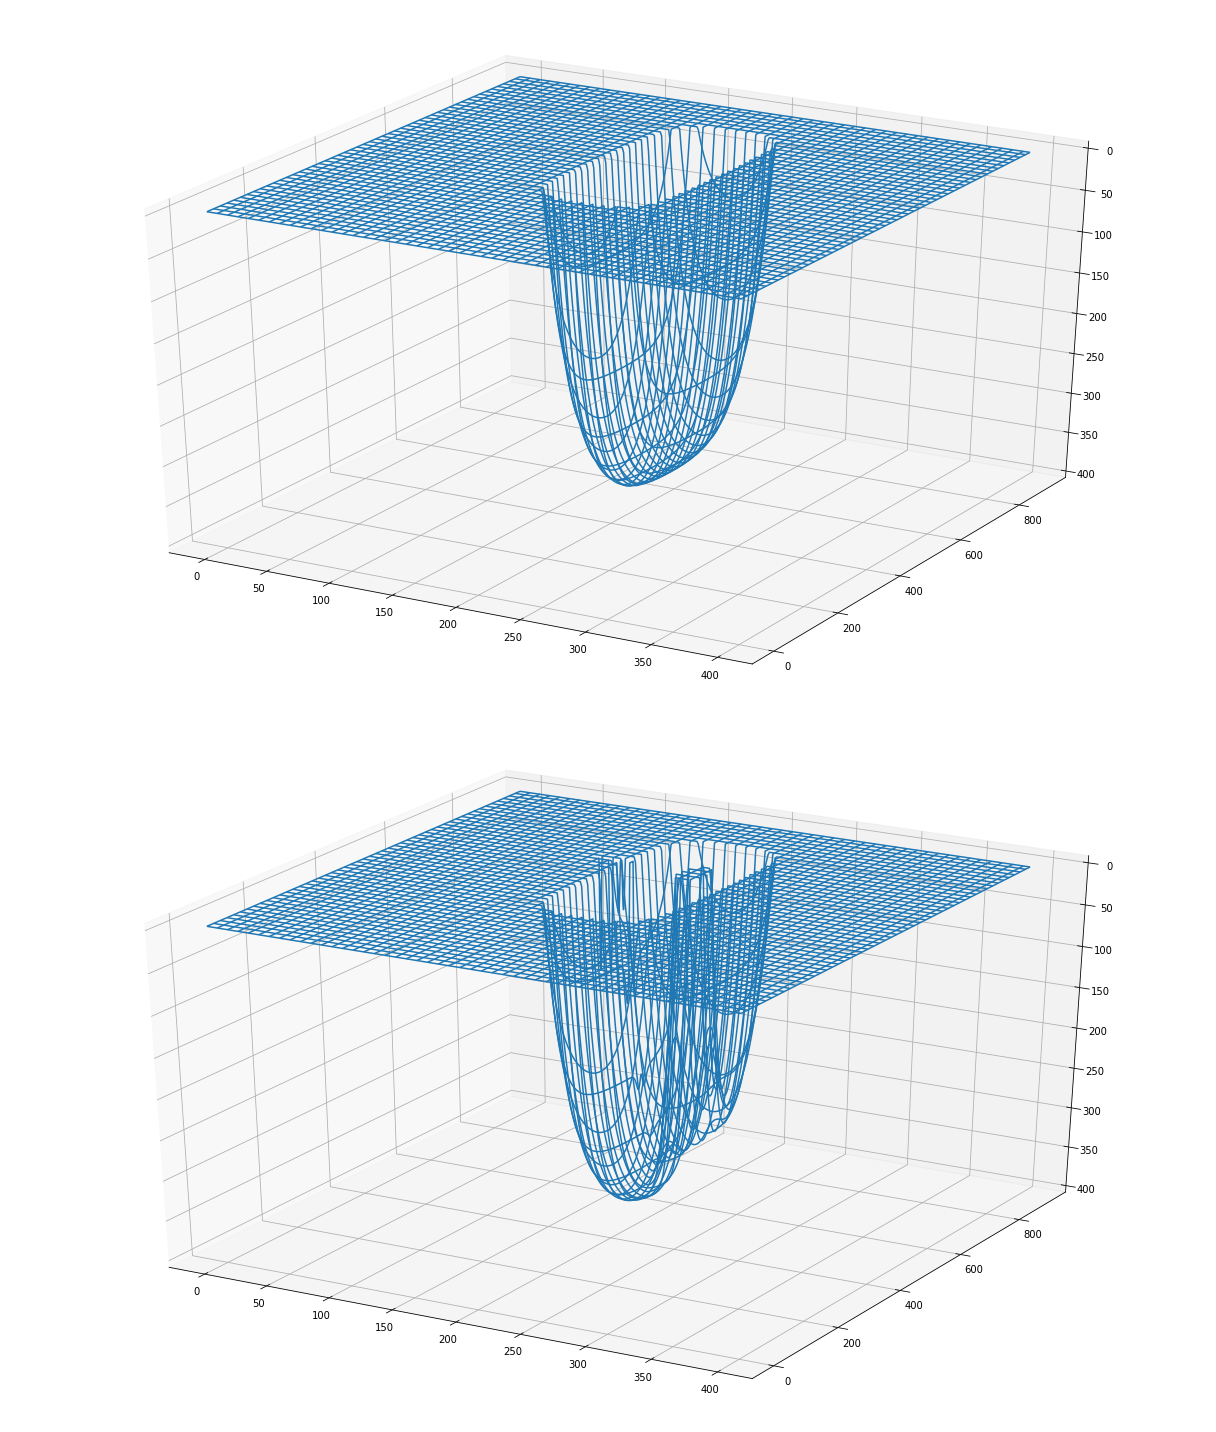

In [5]:
fig = plt.figure(figsize=(17, 20))
for col, Z in zip([1, 2], [z, zzz]):
    ax = fig.add_subplot(2, 1, col, projection='3d')
    ax.plot_wireframe(x, y, Z)
    ax.set_zlim([400, 0])

fig.tight_layout()
plt.show()

**Cross-section at y = 620**

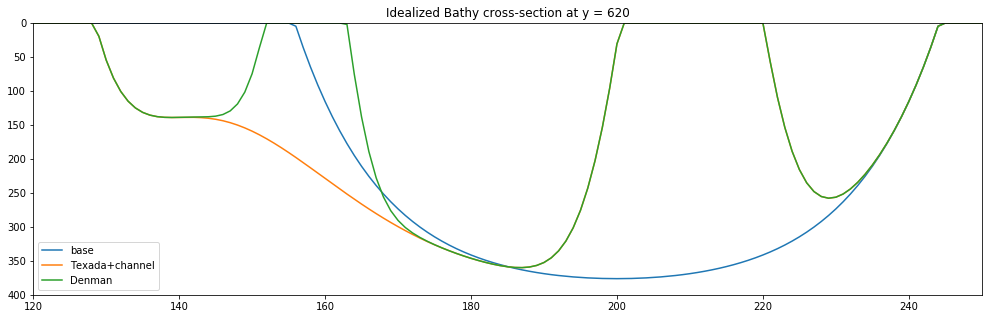

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax.plot(z[620, :], label='base')
ax.plot(zz[620, :], label='Texada+channel')
ax.plot(zzz[620, :], label='Denman')
ax.set_xlim([120, 250])
ax.set_ylim([400, 0])
ax.set_title('Idealized Bathy cross-section at y = 620')
ax.legend()

**Plan view**

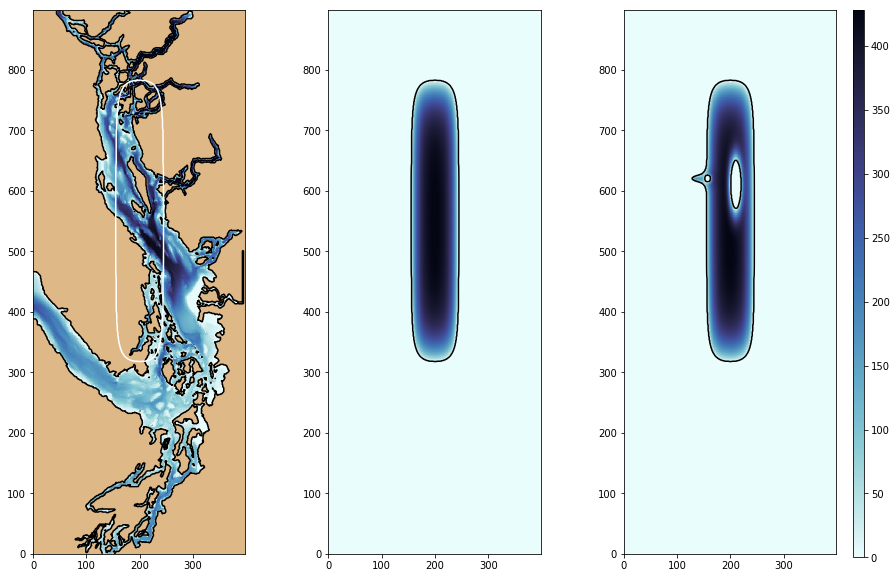

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
for ax in axs:
    ax.set_xlim([0, 398])
    ax.set_ylim([0, 898])
    viz_tools.set_aspect(ax)

c = axs[0].pcolormesh(bathy.Bathymetry, cmap=cmocean.cm.ice_r)
axs[0].contourf(bathy.Bathymetry, levels=[-0.01, 0.01], colors='burlywood')
axs[0].contour(bathy.Bathymetry, levels=[-0.01, 0.01], colors='k')
axs[0].contour(z, levels=1, colors='w')

axs[1].pcolormesh(z, cmap=cmocean.cm.ice_r)
axs[1].contour(z, levels=1, colors='k')

axs[2].pcolormesh(zzz, cmap=cmocean.cm.ice_r)
axs[2].contour(zzz, levels=1, colors='k')

cax = fig.add_axes([0.9, 0.12, 0.01, 0.76])
fig.colorbar(c, cax=cax)

### Save new pond bathy to netCDF

In [8]:
# Update bathy field and save to netCDF
bathy.update({'Bathymetry': (['y', 'x'], z)}).to_netcdf('/data/bmoorema/MEOPAR/grid/pond_bathy201702.nc')

In [9]:
# Load new bathy file
bathypond = xr.open_dataset('/data/bmoorema/MEOPAR/grid/pond_bathy201702.nc', mask_and_scale=False)

(315, 785)

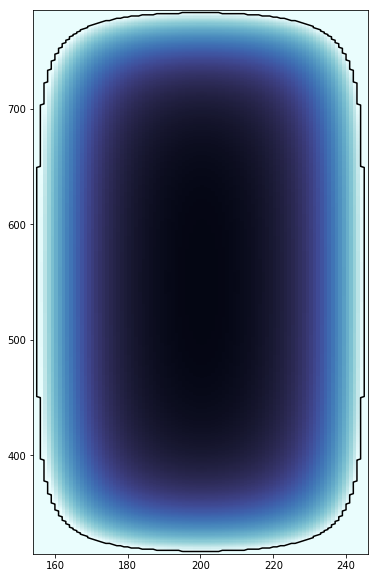

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6, 10))

ax.pcolormesh(z, cmap=cmocean.cm.ice_r)
ax.contour(z, levels=1e-10, colors='k')
ax.set_xlim([154, 246])
ax.set_ylim([315, 785])

### Results

In [3]:
T = xr.open_dataset('/data/bmoorema/MEOPAR/Results/SalishSeaLake_1h_20170601_20170604_ptrc_T.nc')

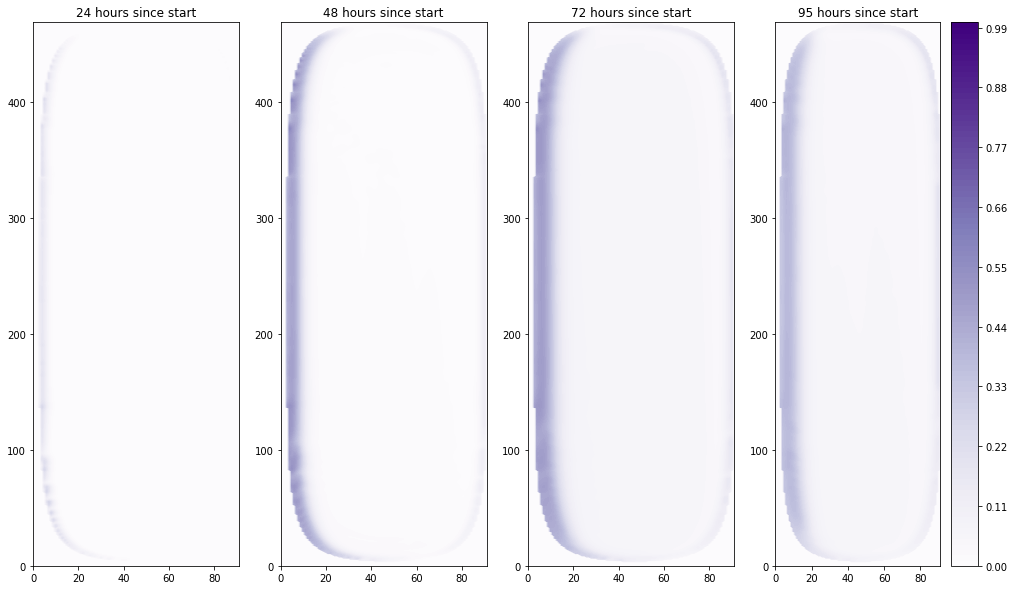

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(17, 10))

for ax, t in zip(axs, [24, 48, 72, 95]):
    c = ax.contourf(T.mytracer1[t, 0, ...], levels=np.arange(0, 1.01, 0.01), cmap="Purples")
    ax.set_title(f'{t} hours since start')

fig.colorbar(c)